# Nishikawa data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

corrientes con las que midieron (en unidades de nA)

In [2]:
currents = np.array([1, 2, 3, 5, 10])

potencial de equilibrio que dan y nuestro potencial de corte (150 mV)

In [3]:
eq_pot = 4.739  # V
vcut = 0.15  # V

Usando que la superficie es de 8.04 $\cdot$ 10$^{-6}$ cm$^2$se obtiene puede obtener el diámetro de la partícula (asumiendo una partícula esférica simple)

In [4]:
d = np.sqrt(0.25 * 8.04e-6 / np.pi)
d

0.0007998767850296815

que equivale a 7.998768 $\mu$m

Para pasar de la corriene en nA a la C-rate que le correspondería

In [5]:
crate = lambda i: 2.5 * i

Lectura de datos obtenidos a mano (ya que la calidad del gráfico es baja y el software no llega a detectar los colores de las curvas) usando [WebPlotDigitzer](https://apps.automeris.io/wpd/)

In [6]:
dfs = []
for i in currents:
    df = pd.read_csv(f"{i}nA.csv", header=None)
    
    df[0] = np.round(df[0], decimals=2)
    df = df.rename(columns={0: "capacity", 1: f"{i}_nA"})
    
    dfs.append(df)

OUTER JOIN de todas las tablas

In [7]:
nishikawa = dfs[0]
for df in dfs[1:]:
    nishikawa = nishikawa.merge(df, right_on="capacity", left_on="capacity", how="outer")
nishikawa.head()

,capacity,1_nA,2_nA,3_nA,5_nA,10_nA
0,0.00,4.82048,4.81566,4.77590,4.74699,4.67831
1,0.01,4.76623,4.75419,4.73611,4.71563,4.66744
2,0.02,4.74211,4.73488,4.72163,4.70476,4.66259
3,0.03,4.73364,4.72642,4.71316,4.69991,4.66135
4,0.04,4.73000,4.72518,4.71193,4.69867,4.66012


plot:

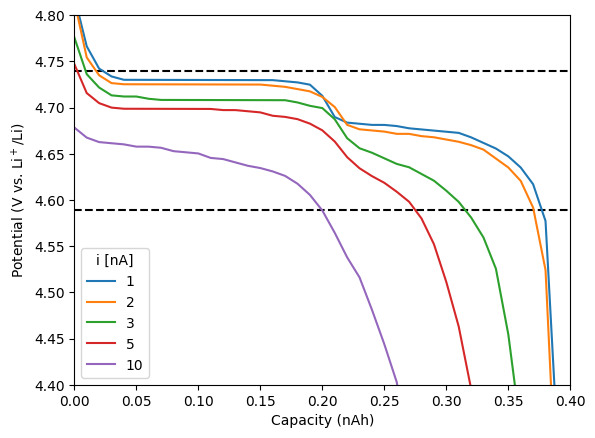

In [8]:
fig, ax = plt.subplots()

# potencial de equilibrio mencionado en el trabajo
ax.axhline(y=eq_pot, color="k", linestyle="--")
# potencial de equilibrio - potencial de corte
ax.axhline(y=eq_pot - vcut, color="k", linestyle="--")
# curvas para cada corriente
for i in currents:
    ax.plot(nishikawa.capacity, nishikawa[f"{i}_nA"], label=f"{i}")

ax.set_xlim((0, 0.4))
ax.set_ylim((4.4, 4.8))
ax.set_xlabel("Capacity (nAh)")
ax.set_ylabel(r"Potential (V vs. Li$^+$/Li)")
ax.legend(title="i [nA]")
plt.show()

Teniendo en cuenta que el potencial medido tiene tres contibuciones:

1. Difusión
2. Transferencia de carga
3. Resistencia

y la última no está considerada en el modelo, podemos restarla si encontramos una relación lineal entre $V$ e $i$ para utilizar la Ley de Ohm y extraer de la pendiente la resistencia.

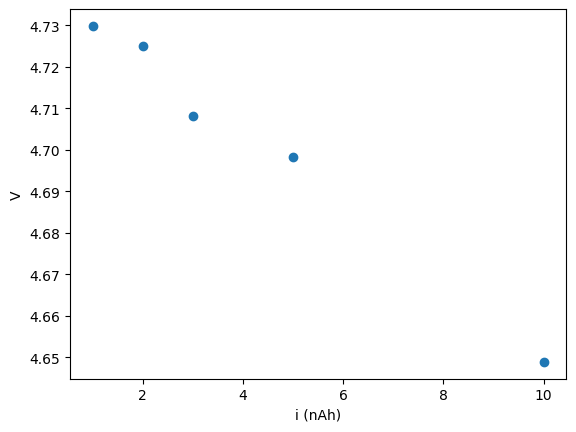

In [9]:
# en la región del plateu veo si se cumple la Ley de Ohm
plateau = np.where((nishikawa.capacity > 0.075) & (nishikawa.capacity < 0.125))[0]

V = np.asarray([np.mean(nishikawa[f"{i}_nA"][plateau]) for i in currents])
    
plt.scatter(currents, V)
plt.xlabel("i (nAh)")
plt.ylabel("V")
plt.show()

Puede ser que esta curva tenga mal el cero (de hecho no pasa por (0, 0)) pero como solo nos interesa la pendiente podemos ajustar una lineal y obtener la resistencia.

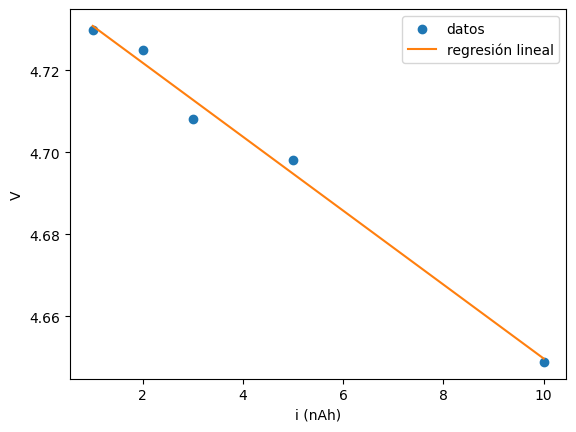

In [10]:
reg = sklearn.linear_model.LinearRegression()
reg.fit(currents.reshape(-1, 1), V)

plt.scatter(currents, V, label="datos")
plt.plot(currents, reg.predict(currents.reshape(-1, 1)), color="tab:orange", label="regresión lineal")
plt.xlabel("i (nAh)")
plt.ylabel("V")
plt.legend()
plt.show()

La pendiente de este ajuste nos da la resistencia en unidades de V / nA. El signo puede ser positivo o negativo según si al electrodo se lo está cargando o descargando.

In [11]:
R = np.abs(reg.coef_[0])
R

0.009019984251968457

Además, resto el potencial de equilibrio para tenerlo en la misma escala que el modelo de maxi.

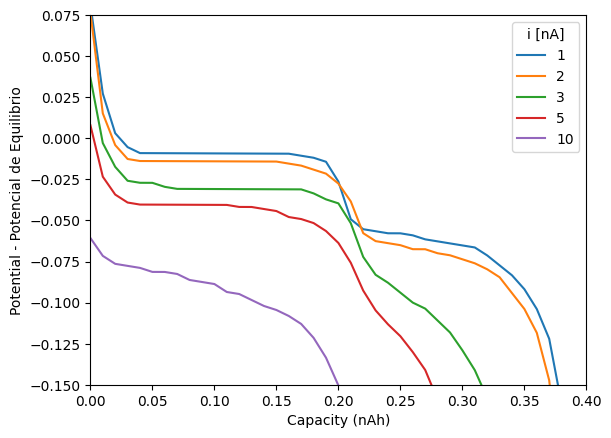

In [12]:
fig, ax = plt.subplots()

for i in currents:
    # por ahora no restamos la resistencia
    nishikawa[f"{i}_nA"] = nishikawa[f"{i}_nA"] - eq_pot# + i * R
    ax.plot(nishikawa.capacity, nishikawa[f"{i}_nA"], label=f"{i}")
    ax.set_xlim((0, 0.4))
ax.set_ylim((-0.15, 0.075))
ax.set_xlabel("Capacity (nAh)")
ax.set_ylabel(r"Potential - Potencial de Equilibrio")
ax.legend(title="i [nA]")
plt.show()

Veamos ahora los puntos para los cuales el voltaje alcanza los -150 mV

2.5 0.365
5.0 0.355
7.5 0.315
12.5 0.255
25.0 0.195


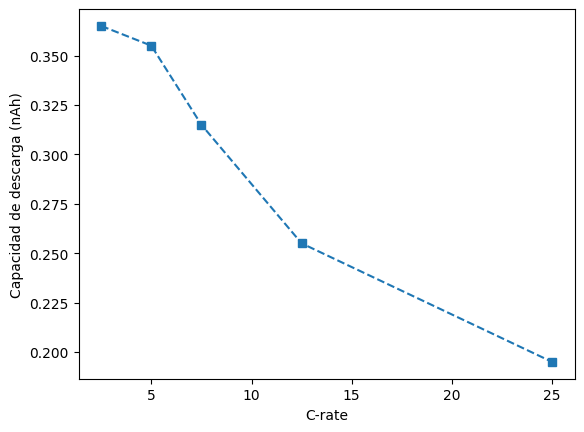

In [13]:
# uno con una recta los valores consecutivos que pasan por -0.15 y tomo el x medio
# obviamente esto puede mejorarse, es sólo una primera aproximación
crates = [crate(i) for i in currents]
xmax = []
x = nishikawa.capacity
tols = (0.05, 0.05, 0.02, 0.035, 0.02)
for i, tol in zip(currents, tols):
    y = nishikawa[f"{i}_nA"]
    idxs = np.where((y > -0.15 - tol) & (y < -0.15 + tol))[0]
    
    xprom = (x[idxs[0]] + x[idxs[1]]) / 2
    xmax.append(xprom)
    
    print(crate(i), xprom)
    
plt.plot(crates, xmax, marker="s", linestyle="--")
plt.xlabel("C-rate")
plt.ylabel("Capacidad de descarga (nAh)")
plt.show()

Quizás podrían tenerse los datos de nishikawa con mayor precisión y eso mostraría las curvas más suaves pero, como mencioné, el software falla al reconocer las curvas debido a que son muy finas y la calidad de la imagen no es muy buena.

Ahora con estos datos de capacidad máxima de descarga (normalizada) vs las C rates, podemos encontrar en el mapa el mejor set de parámetros $D$ y $k_0$ que reproducen y minimizan las diferencias de la curva anterior. Para esto escribí una librería de python que junta todos estos códigos por lo que las siguientes celdas sólo llaman a classes/funciones que se encuentran ahí:

In [14]:
from galpynostatic.datasets import load_spherical
from galpynostatic.model import GalvanostaticModel

crates = np.asarray(crates)
xmax = np.asarray(xmax) / 0.375

dataset = load_spherical()
gm = GalvanostaticModel(dataset, d, 3)

gm.fit(crates, xmax)

El coeficiente de difusión que se obtiene de esta cuenta es el siguiente (en cm$^2$/s)

In [15]:
gm.dcoeff_

1.5848931924610332e-09

la constate cinética (cm/s)

In [16]:
gm.k0_

6.309573444801529e-07

y el error cuadrático medio entre los resultados de nishikawa y los valores predichos por el modelo

In [17]:
gm.mse_

0.0007644861444444441

Podemos graficar los datos y las predicciones del modelo para visualizar las curvas

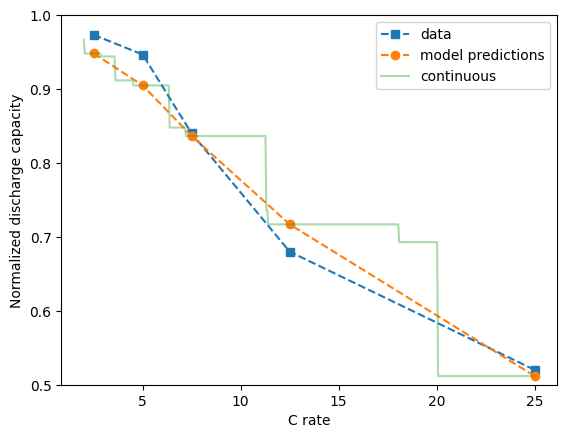

In [18]:
fig, ax = plt.subplots()
gm.plot_vs_data(crates, xmax, ax=ax)

x = np.linspace(2, 25, num=500)
ax.plot(x, gm.predict(x), alpha=0.4, label="continuous")

ax.set_ylim((0.5, 1))
ax.set_xlabel("C rate")
ax.set_ylabel("Normalized discharge capacity")

ax.legend()

Hay una gran concordancia entre los datos y las predicciones pero vale la pena mencionar que la curva no es continúa si no que es escalonada y tiene la precisión que se tiene en el mapa realizado por maxi (para mayor precisión podríamos volver a correr estas simulaciones con un delta en $\ell$ y $\Xi$ mucho más pequeño). De una manera similar, también depende de los $D$ y $k_0$ que se prueben (cuando usaba un grillado con menor precisión me daba 1.5e-8, ahora con un grillado más fino da 1.5e-9, podría probarse un grillado aún más fino).

Podemos graficar también la región del mapa en la cual se encuentran estos puntos:

/home/ffernandez/.local/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=29,39 m=990 fp=0.000015 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


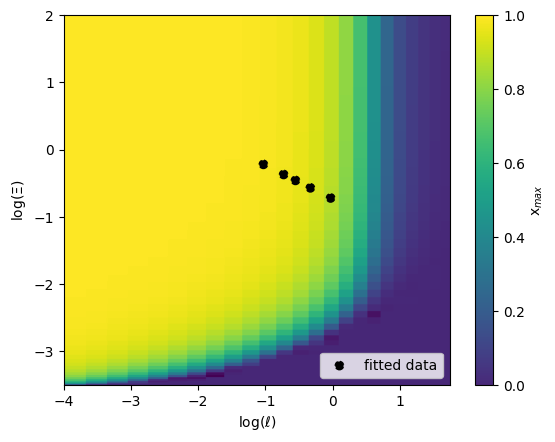

In [19]:
fig, ax = plt.subplots()
gm.plot_in_surface(crates, ax=ax)

ax.legend()

Ahora podemos, con estos parámetros obtenidos, correr las curvas completas con el programa de Maxi. Leemos los archivos obtenidos y los de nishikawa sin alterar por el análisis previo para obtener la curva de descarga:

In [20]:
nishikawas, maxis = [], []
for i in currents:
    nish = pd.read_csv(f"{i}nA.csv", header=None)
    nish = nish.rename(columns={0: "capacity", 1: "E"})
    nishikawas.append(nish)
    
    maxi = pd.read_csv(f"{i}nA-simulated.csv")
    maxis.append(maxi)

Normalizamos los datos de nishikawa por la capacidad máxima:

In [21]:
capacity_max = 0.38
for nish in nishikawas:
    nish.capacity = nish.capacity / capacity_max

Y ahora graficamos

Text(0, 0.5, 'V vs. Li$^+$/Li')

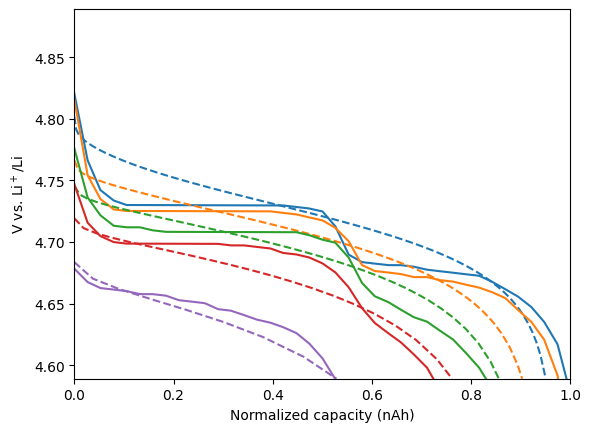

In [22]:
fig, ax = plt.subplots()

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
for nish, maxi, color in zip(nishikawas, maxis, colors):
    ax.plot(nish.capacity, nish.E, color=color)
    ax.plot(maxi.theta, maxi.E, color=color, linestyle="--")
    
ax.set_xlim((0, 1))
ax.set_ylim((eq_pot - vcut, eq_pot + vcut))
ax.set_xlabel("Normalized capacity (nAh)")
ax.set_ylabel(r"V vs. Li$^+$/Li")

Las líneas continuas se corresponden con los experimentos y las discontinuas con las simulaciones.

Como esperabamos, el quiebre de los dos plateaus que se ve en el experimento no es reproducible debido al modelo que se utiliza, aún así podemos apreciar como sólo ajustando con los puntos de las capacidades máximas se logra reproducir el comportamiento cualitativo de las curvas dentro del mismo orden de valores.